In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.colab import drive
import pickle
import librosa
from itertools import combinations 
import keras
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path ='/content/drive/My Drive/assignment4/'
f = open(path + 'hw4_tr7.pkl','rb') 
train = pickle.load(f)


f = open(path + 'hw4_te7.pkl','rb') 
test = pickle.load(f)

In [0]:
batchsize = 64
epochs = 1000
learning_rate = 0.0001
dropout = 0.1
iterations = int(len(train)/batchsize)
lunits=4

In [0]:
def batchgen(x,st,batch_size):
    return x[st:st + batch_size]

In [0]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,28,28])
X_reshape = tf.reshape(X, shape=[-1, 28 * 28])

ENCODER

In [0]:
l1 = tf.reshape(X,[-1,28,28,1])
l2 = tf.layers.conv2d(l1, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu,kernel_initializer= tf.keras.initializers.glorot_normal())
l3 = tf.layers.dropout(l2, dropout)
l4 = tf.layers.conv2d(l3, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu,kernel_initializer= tf.keras.initializers.glorot_normal())
l5 = tf.layers.dropout(l4, dropout)
l6 = tf.layers.flatten(l5)
mean1 = tf.layers.dense(l6, lunits, kernel_initializer= tf.keras.initializers.glorot_normal())
sd = tf.layers.dense(mean1, lunits, kernel_initializer= tf.keras.initializers.glorot_normal(), activation=tf.nn.softplus)
epsilon = tf.random_normal([tf.shape(l6)[0],lunits])
final  = mean1 + epsilon*sd

DECODER

In [0]:
dl1 = tf.layers.dense(final, 49,activation=tf.nn.relu, kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
dl2 = tf.reshape(dl1,[-1,7,7,1])
dl3 = tf.layers.conv2d_transpose(dl2, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu,kernel_initializer= tf.keras.initializers.glorot_normal())
dl4 = tf.layers.dropout(dl3, dropout)
dl5 = tf.layers.conv2d_transpose(dl4, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu,kernel_initializer= tf.keras.initializers.glorot_normal())
dl6 = tf.layers.dropout(dl5, dropout)
dl7 = tf.layers.conv2d(dl6, filters=1, kernel_size=3, strides=1, padding='same', activation=tf.sigmoid,kernel_initializer= tf.keras.initializers.glorot_normal())
final_img = tf.reshape(dl7, shape=[-1, 28, 28])

In [0]:
sample=final
rec_img = final_img
mean=mean1

In [0]:
img_flat = tf.reshape(rec_img, shape=[-1, 28 * 28])
rec_loss = tf.reduce_sum(tf.squared_difference(img_flat, X_reshape), 1)
kldiv = -0.5 * tf.reduce_sum(1.0 + 2.0 * tf.log(sd) - tf.square(mean) - tf.square(sd), 1)
loss = tf.reduce_mean(rec_loss + kldiv)
train_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)   

Loss for epoch 0 = 123.2306900024414


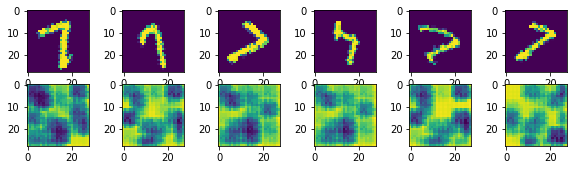

Loss for epoch 150 = 39.84988021850586


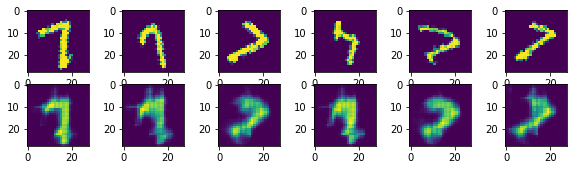

Loss for epoch 300 = 36.196449279785156


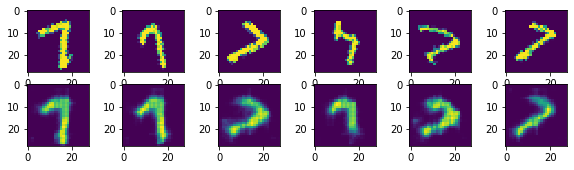

Loss for epoch 450 = 34.096641540527344


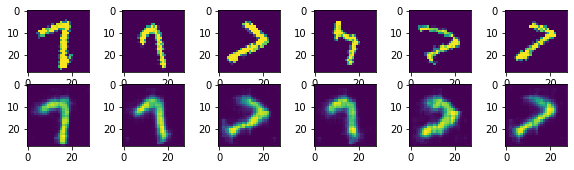

Loss for epoch 600 = 32.4556884765625


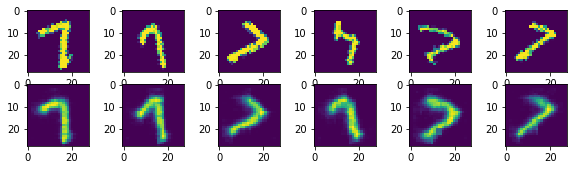

Loss for epoch 750 = 31.830020904541016


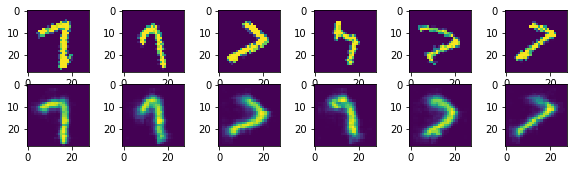

Loss for epoch 900 = 31.568302154541016


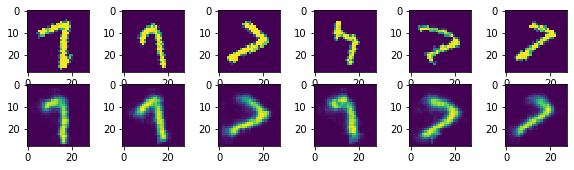

In [143]:
saver = tf.train.Saver()
with tf.Session()  as sess:
  tf.global_variables_initializer().run()
  cost = np.zeros(epochs)
  for i in range(epochs):    
    for itr in range(iterations):
      x_batch = batchgen(train,itr*batchsize,batchsize)
      sess.run(train_optimizer, feed_dict={X:x_batch})
    cost[i],img = sess.run([loss,rec_img],feed_dict={X:test})
    saver.save(sess, "Model")
    if i%150 == 0:
      print("Loss for epoch",str(i),"=", str(cost[i]))
      np.random.seed(1234) 
      n = np.random.randint(20,len(test),200)
      original = [test[i] for i in n]
      img = [img[i] for i in n]
      fig=plt.figure(figsize=(10,2.5))
      for i in range(1, 13):
          if i <7:
            img_p = original[i-1]
          else: 
            img_p = img[i-7]
          fig.add_subplot(2, 6, i)          
          plt.imshow(img_p)
      plt.show()  


Generating inputs and plotting the decoded outputs

In [147]:
X = np.array([np.random.normal(0, 1, lunits-1) for i in range(10)])
Y = np.array([i/10 for i in range(-10,10,2)])
N1 = np.hstack((Y.reshape(10,1),X))
N2 = N1[:, [1, 0, 2, 3]]
N3 = N1[:, [1, 2, 0, 3]]
N4 = N1[:, [1, 2, 3, 0]]
newinp = np.vstack((N1,N2,N3,N4))
#random.shuffle(newinp)
with tf.Session() as sess:
  saver.restore(sess, "Model")
  out_img  = sess.run(rec_img,{sample:newinp})

INFO:tensorflow:Restoring parameters from Model


In [148]:
out_img.shape

(40, 28, 28)

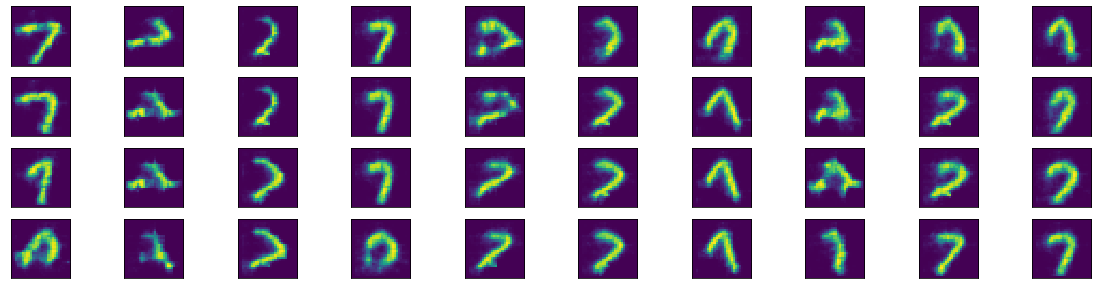

In [152]:
fig=plt.figure(figsize=(20, 5))
for i in range(1, 41):
    img_1 = out_img[i-1]       
    fig.add_subplot(4, 10, i)          
    plt.imshow(img_1)
    plt.xticks([])
    plt.yticks([])
plt.show()

X-axis are the samples and Y-axis are the dimensions